In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Знакомство с данными

In [86]:
data = pd.read_csv('./data/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206474 entries, 0 to 206473
Data columns (total 76 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   city                                 206474 non-null  object 
 1   floor                                76209 non-null   float64
 2   id                                   206474 non-null  object 
 3   lat                                  206474 non-null  float64
 4   lng                                  206474 non-null  float64
 5   osm_amenity_points_in_0.001          206474 non-null  int64  
 6   osm_amenity_points_in_0.005          206474 non-null  int64  
 7   osm_amenity_points_in_0.0075         206474 non-null  int64  
 8   osm_amenity_points_in_0.01           206474 non-null  int64  
 9   osm_building_points_in_0.001         206474 non-null  int64  
 10  osm_building_points_in_0.005         206474 non-null  int64  
 11  osm_building_

Для начала определимся со столбцом, который мы предсказываем - `per_square_meter_price`.

Столбцы с непонятными названиями с дробями.

* `in 0.001`  - в радиусе 100 метров
* `in 0.005`  - в радиусе 500 метров
* `in 0.0075` - в радиусе 750 метров
* `in 0.01`   - в радиусе 1 километра
* `amenity`   - объекты, связанные с удобством
* `catering`  - заведения общественного питания
* `reform_count_of_houses_1000` - количество домов в радиусе километра
* `reform_house_population_1000` - коэффициент количества людей, проживающих в радиусе километра
* `reform_mean_floor_count_1000` - средняя этажность домов в радиусе километра
* `reform_mean_year_building_1000` - количество строящихся домов в радиусе километра

И далее по аналогии.

## Смотрим на столбцы

Правда ли, что `id` одинаковые?

In [87]:
len(data) == data.id.nunique()

True

Нас вполне устраивают индексы, а `id` можно удалить

In [88]:
data = data.drop(columns=["id"])

Каких данных нам недостает?

`floor`

`reform_house_population_1000`

`reform_house_population_500`

`reform_mean_floor_count_1000`

`reform_mean_floor_count_500`

`reform_mean_year_building_1000`

`reform_mean_year_building_500`

Чтобы решить, будем ли мы как-то восстанавливать эти данные, посмотрим на корреляции.

In [89]:
data.filter(["per_square_meter_price", "floor", "reform_house_population_1000", "reform_house_population_500", "reform_mean_floor_count_1000", "reform_mean_floor_count_500", "reform_mean_year_building_1000", "reform_mean_year_building_500"]).corr(numeric_only=True)[1:].filter(["per_square_meter_price"])

,per_square_meter_price
floor,0.185877
reform_house_population_1000,0.240658
reform_house_population_500,0.145787
reform_mean_floor_count_1000,0.165567
reform_mean_floor_count_500,0.114983
reform_mean_year_building_1000,-0.083208
reform_mean_year_building_500,-0.073135


Выкинем все столбцы с абсолютной корреляцией < 0.2

In [90]:
low_corr = ["floor", "reform_house_population_500", "reform_mean_floor_count_1000", "reform_mean_floor_count_500", "reform_mean_year_building_1000", "reform_mean_year_building_500"]
data = data.drop(columns=low_corr)

Как будем восстанавливать `reform_house_population_1000`?

<AxesSubplot:>

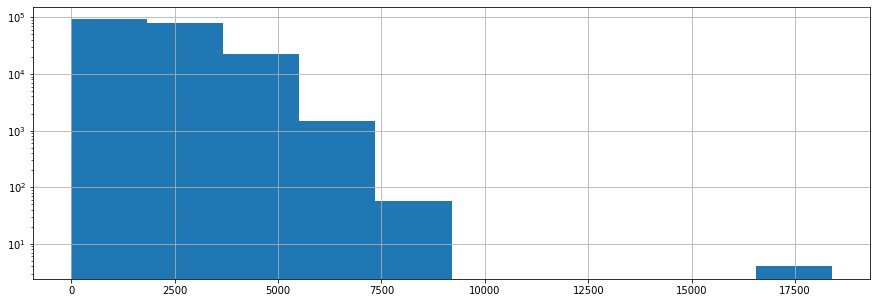

In [91]:
data.reform_house_population_1000.dropna().hist(figsize=(15,5), log=True)

In [92]:
# данных всего = 206474
print('процент пропусков:', (len(data) - data.reform_house_population_1000.count()) / len(data) * 100)
data.reform_house_population_1000.describe()

процент пропусков: 5.295097687844475


count    195541.000000
mean       2031.848114
std        1355.356057
min           0.000000
25%         917.000000
50%        1946.000000
75%        2970.000000
max       18392.000000
Name: reform_house_population_1000, dtype: float64

Попробуем заполнить медианой.

In [93]:
data.reform_house_population_1000.fillna(data.reform_house_population_1000.dropna().median(), inplace=True)
data.reform_house_population_1000.describe()

count    206474.000000
mean       2027.302372
std        1319.124230
min           0.000000
25%         982.000000
50%        1946.000000
75%        2906.000000
max       18392.000000
Name: reform_house_population_1000, dtype: float64

<AxesSubplot:>

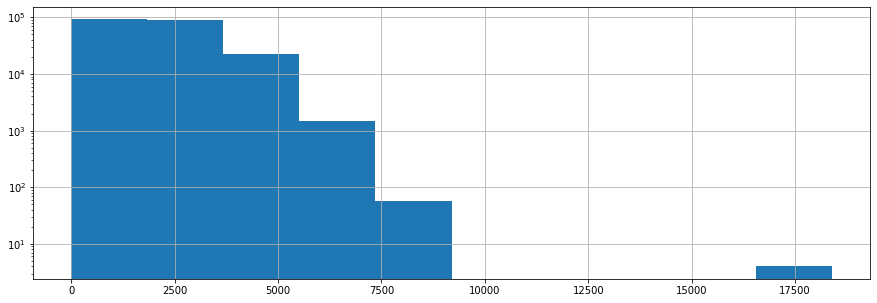

In [94]:
data.reform_house_population_1000.hist(figsize=(15,5), log=True)

Отличное напоминание для чистки данных от выбросов. Но прежде:

Вряд ли географические координаты влияют на стоимость недвижимости в России. Координаты нужно только для определения новых фич, коих мы вносить не будем.

In [95]:
data.drop(columns=["lat", "lng"], inplace=True)

Остаются столбцы с типом данных `object`:

* `city`
* `osm_city_nearest_name`
* `region`
* `street`
* `date`

In [96]:
data.city.nunique(), data.osm_city_nearest_name.nunique(), data.region.nunique(), data.street.nunique()

(4431, 170, 49, 24559)

Сделаем one-hot encoding по столбцу `region`.

In [97]:
data = pd.get_dummies(data, columns=["region"])

Введем новую колонку - помещение находится в городе, `in_city`.

In [98]:
data = data.assign(in_city=(data.city == data.osm_city_nearest_name) * 1.0)
data.in_city.head(5)

0    1.0
1    1.0
2    1.0
3    0.0
4    1.0
Name: in_city, dtype: float64

В целом, все остальное можно удалять.

In [99]:
data.drop(columns=["city", "osm_city_nearest_name", "street", "date"], inplace=True)

Есть столбец `realty_type`, который непонятно как рассматривать. Видимо, как категориальное значение. Если это так, необходимо применить one-hot encoding.

In [100]:
data.realty_type.value_counts()

10     109682
110     54927
100     41865
Name: realty_type, dtype: int64

In [101]:
data = pd.get_dummies(data, columns=["realty_type"])

## Выбросы

In [102]:
data.describe()

,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,...,region_Тюменская область,region_Удмуртия,region_Ульяновская область,region_Ханты-Мансийский АО,region_Челябинская область,region_Ярославская область,in_city,realty_type_10,realty_type_100,realty_type_110
count,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,...,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000,206474.000000
mean,2.686672,40.283300,80.950328,132.200800,0.038155,0.891488,2.058400,3.777812,0.607500,8.698185,...,0.024318,0.009430,0.007270,0.010723,0.033050,0.008287,0.736441,0.531215,0.202762,0.266024
std,4.180174,52.692116,103.803026,169.929844,0.397521,6.963436,14.904702,25.857563,1.685117,17.404241,...,0.154034,0.096648,0.084952,0.102995,0.178768,0.090654,0.440564,0.499026,0.402057,0.441878
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,7.000000,16.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,22.000000,46.000000,77.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,4.000000,51.000000,100.000000,164.000000,0.000000,0.000000,1.000000,2.000000,0.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,46.000000,454.000000,850.000000,1392.000000,27.000000,586.000000,949.000000,1157.000000,23.000000,162.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Детектим выбросы по правилу трех сигм.

In [103]:
means = data.mean()
std = data.std()

mask = None
for column in data.columns:
    if data[column].max() <= 1.0:
        continue
    m = (data[column] > means[column] - 3 * std[column]) & (data[column] < means[column] + 3 * std[column])
    if mask is None:
        mask = m
    else:
        mask &= m

data1 = data[mask].copy()
data1.describe()

,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,...,region_Тюменская область,region_Удмуртия,region_Ульяновская область,region_Ханты-Мансийский АО,region_Челябинская область,region_Ярославская область,in_city,realty_type_10,realty_type_100,realty_type_110
count,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,...,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000,152410.000000
mean,1.588754,23.868598,49.041454,81.172836,0.009796,0.300374,0.719093,1.336487,0.238928,3.627728,...,0.028509,0.011502,0.007854,0.010111,0.039518,0.010085,0.727564,0.556525,0.186602,0.256873
std,2.225652,23.839169,47.060820,77.120733,0.098489,1.142358,2.475536,4.883997,0.640572,5.619027,...,0.166421,0.106629,0.088273,0.100044,0.194825,0.099915,0.445215,0.496796,0.389593,0.436910
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,6.000000,13.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,17.000000,35.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,2.000000,34.000000,71.000000,116.000000,0.000000,0.000000,0.000000,1.000000,0.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,15.000000,174.000000,332.000000,595.000000,1.000000,21.000000,46.000000,81.000000,5.000000,59.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Нормализация и центрирование

In [104]:
for column in data1.columns:
    # log target column
    if column == 'per_square_meter_price':
        data1[column] = data1[column].apply(np.log)
        continue
    data1[column] = (data1[column] - data1[column].mean()) / (data1[column].max() - data1[column].min())

data1.describe()

,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,...,region_Тюменская область,region_Удмуртия,region_Ульяновская область,region_Ханты-Мансийский АО,region_Челябинская область,region_Ярославская область,in_city,realty_type_10,realty_type_100,realty_type_110
count,1.524100e+05,1.524100e+05,1.524100e+05,1.524100e+05,1.524100e+05,1.524100e+05,1.524100e+05,1.524100e+05,1.524100e+05,1.524100e+05,...,1.524100e+05,1.524100e+05,1.524100e+05,152410.000000,1.524100e+05,1.524100e+05,1.524100e+05,1.524100e+05,1.524100e+05,1.524100e+05
mean,-9.697060e-18,4.685358e-18,-4.574635e-19,-2.402412e-18,3.068210e-18,-7.765224e-19,3.537329e-18,7.109623e-19,-8.461617e-18,-1.981370e-19,...,1.617148e-17,-3.193503e-18,-3.886983e-18,0.000000,1.841509e-18,6.410316e-19,-3.881155e-17,5.557161e-17,2.843849e-18,-6.876521e-18
std,1.483768e-01,1.370067e-01,1.417495e-01,1.296147e-01,9.848882e-02,5.439799e-02,5.381599e-02,6.029626e-02,1.281145e-01,9.523774e-02,...,1.664214e-01,1.066286e-01,8.827335e-02,0.100044,1.948254e-01,9.991499e-02,4.452146e-01,4.967963e-01,3.895929e-01,4.369101e-01
min,-1.059169e-01,-1.371758e-01,-1.477152e-01,-1.364249e-01,-9.795945e-03,-1.430352e-02,-1.563246e-02,-1.649984e-02,-4.778558e-02,-6.148691e-02,...,-2.850863e-02,-1.150187e-02,-7.853815e-03,-0.010111,-3.951840e-02,-1.008464e-02,-7.275638e-01,-5.565252e-01,-1.866019e-01,-2.568729e-01
25%,-1.059169e-01,-1.026931e-01,-1.085586e-01,-9.776947e-02,-9.795945e-03,-1.430352e-02,-1.563246e-02,-1.649984e-02,-4.778558e-02,-6.148691e-02,...,-2.850863e-02,-1.150187e-02,-7.853815e-03,-0.010111,-3.951840e-02,-1.008464e-02,-7.275638e-01,-5.565252e-01,-1.866019e-01,-2.568729e-01
50%,-3.925027e-02,-3.947470e-02,-4.229354e-02,-3.558460e-02,-9.795945e-03,-1.430352e-02,-1.563246e-02,-1.649984e-02,-4.778558e-02,-2.758861e-02,...,-2.850863e-02,-1.150187e-02,-7.853815e-03,-0.010111,-3.951840e-02,-1.008464e-02,2.724362e-01,4.434748e-01,-1.866019e-01,-2.568729e-01
75%,2.741640e-02,5.822645e-02,6.614020e-02,5.853305e-02,-9.795945e-03,-1.430352e-02,-1.563246e-02,-4.154162e-03,-4.778558e-02,2.325885e-02,...,-2.850863e-02,-1.150187e-02,-7.853815e-03,-0.010111,-3.951840e-02,-1.008464e-02,2.724362e-01,4.434748e-01,-1.866019e-01,7.431271e-01
max,8.940831e-01,8.628242e-01,8.522848e-01,8.635751e-01,9.902041e-01,9.856965e-01,9.843675e-01,9.835002e-01,9.522144e-01,9.385131e-01,...,9.714914e-01,9.884981e-01,9.921462e-01,0.989889,9.604816e-01,9.899154e-01,2.724362e-01,4.434748e-01,8.133981e-01,7.431271e-01


## Подготовка машинерии

In [105]:
from sklearn.linear_model import LinearRegression

In [106]:
def train(train_X, train_Y):
    model = LinearRegression(fit_intercept=True)
    model.fit(train_X, train_Y)
    return model, model.score(train_X, train_Y)

In [107]:
def get_model(data, column):
    train_X = data.drop(columns=[column]).to_numpy()
    train_Y = data[column].array
    return train(train_X, train_Y)

In [108]:
model, score = get_model(data1, "per_square_meter_price")
score

0.4602740335105707

Мы линейной моделью объяснили 46% дисперсии. Пока примем на веру, что это хорошо.

## Получаем значение `per_square_meter_price`

In [109]:
final = pd.read_csv('./data/test_x.csv')

In [110]:
final = final.drop(columns=[
    "id",
    "floor",
    "lat",
    "lng"
])

<AxesSubplot:>

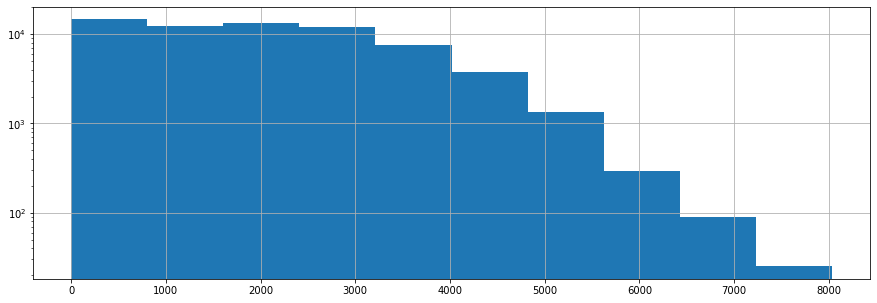

In [111]:
final.reform_house_population_1000.dropna().hist(figsize=(15,5), log=True)

In [112]:
print('процент пропусков:', (len(final) - final.reform_house_population_1000.count()) / len(final) * 100)
final.reform_house_population_1000.describe()

процент пропусков: 5.242281147838721


count    65217.000000
mean      2031.103792
std       1355.565429
min          0.000000
25%        915.000000
50%       1946.000000
75%       2977.000000
max       8034.000000
Name: reform_house_population_1000, dtype: float64

Заполняем медианой.

In [113]:
final.reform_house_population_1000.fillna(final.reform_house_population_1000.dropna().median(), inplace=True)
final.reform_house_population_1000.describe()

count    68825.000000
mean      2026.642412
std       1319.691660
min          0.000000
25%        980.000000
50%       1946.000000
75%       2908.000000
max       8034.000000
Name: reform_house_population_1000, dtype: float64

Какие колонки еще могут быть неполными?

In [114]:
final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68825 entries, 0 to 68824
Data columns (total 71 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   city                                 68825 non-null  object 
 1   osm_amenity_points_in_0.001          68825 non-null  int64  
 2   osm_amenity_points_in_0.005          68825 non-null  int64  
 3   osm_amenity_points_in_0.0075         68825 non-null  int64  
 4   osm_amenity_points_in_0.01           68825 non-null  int64  
 5   osm_building_points_in_0.001         68825 non-null  int64  
 6   osm_building_points_in_0.005         68825 non-null  int64  
 7   osm_building_points_in_0.0075        68825 non-null  int64  
 8   osm_building_points_in_0.01          68825 non-null  int64  
 9   osm_catering_points_in_0.001         68825 non-null  int64  
 10  osm_catering_points_in_0.005         68825 non-null  int64  
 11  osm_catering_points_in_0.007

Заполним `osm_city_nearest_population` тоже медианой.

In [115]:
final.osm_city_nearest_population.fillna(final.osm_city_nearest_population.dropna().median(), inplace=True)
final.osm_city_nearest_population.describe()

count    6.882500e+04
mean     2.601089e+06
std      4.130465e+06
min      4.438900e+04
25%      2.622500e+05
50%      1.013468e+06
75%      1.468833e+06
max      1.263029e+07
Name: osm_city_nearest_population, dtype: float64

one-hot encoding по `region`

In [116]:
final = pd.get_dummies(final, columns=["region"])

Синтезируем `in_city`

In [117]:
final = final.assign(in_city=(final.city == final.osm_city_nearest_name) * 1.0)

Удаляем более ненужные столбцы

In [118]:
final = final.drop(columns=[
    "city",
    "osm_city_nearest_name",
    "street",
    "date"
])

Конвертируем `realty_type`.

In [119]:
final.realty_type.value_counts()

10     36330
110    18329
100    14166
Name: realty_type, dtype: int64

In [120]:
final = pd.get_dummies(final, columns=["realty_type"])

In [121]:
final = final.dropna(axis=1)

Нормализация и центрирование

In [122]:
for column in final.columns:
    final[column] = (final[column] - final[column].mean()) / (final[column].max() - final[column].min())

final.describe()

,osm_amenity_points_in_0.001,osm_amenity_points_in_0.005,osm_amenity_points_in_0.0075,osm_amenity_points_in_0.01,osm_building_points_in_0.001,osm_building_points_in_0.005,osm_building_points_in_0.0075,osm_building_points_in_0.01,osm_catering_points_in_0.001,osm_catering_points_in_0.005,...,region_Тюменская область,region_Удмуртия,region_Ульяновская область,region_Ханты-Мансийский АО,region_Челябинская область,region_Ярославская область,in_city,realty_type_10,realty_type_100,realty_type_110
count,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,...,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04,6.882500e+04
mean,-1.438894e-18,-8.310743e-18,-3.406889e-18,-7.484831e-19,-1.250160e-19,-3.484318e-19,-1.967994e-19,1.225964e-19,-3.000385e-19,-2.813264e-18,...,8.413982e-18,5.161952e-20,3.213315e-18,1.445347e-18,6.839587e-19,-1.834106e-18,8.930177e-18,7.949407e-18,1.099496e-17,-1.693120e-17
std,9.110542e-02,1.120619e-01,1.212529e-01,1.215181e-01,1.274145e-02,2.281689e-02,2.045468e-02,2.231163e-02,7.325451e-02,1.026051e-01,...,1.532398e-01,9.811198e-02,8.364987e-02,1.053148e-01,1.769104e-01,9.007425e-02,4.403831e-01,4.992268e-01,4.043071e-01,4.420331e-01
min,-5.900409e-02,-8.610206e-02,-9.507833e-02,-9.509516e-02,-1.219518e-03,-3.038214e-03,-2.852520e-03,-3.269098e-03,-2.665930e-02,-5.148905e-02,...,-2.406102e-02,-9.720305e-03,-7.046858e-03,-1.121685e-02,-3.234290e-02,-8.180167e-03,-7.367817e-01,-5.278605e-01,-2.058264e-01,-2.663131e-01
25%,-5.900409e-02,-7.114480e-02,-7.625480e-02,-7.495128e-02,-1.219518e-03,-3.038214e-03,-2.852520e-03,-3.269098e-03,-2.665930e-02,-5.148905e-02,...,-2.406102e-02,-9.720305e-03,-7.046858e-03,-1.121685e-02,-3.234290e-02,-8.180167e-03,-7.367817e-01,-5.278605e-01,-2.058264e-01,-2.663131e-01
50%,-3.726496e-02,-3.909351e-02,-4.096068e-02,-3.969948e-02,-1.219518e-03,-3.038214e-03,-2.852520e-03,-3.269098e-03,-2.665930e-02,-3.965473e-02,...,-2.406102e-02,-9.720305e-03,-7.046858e-03,-1.121685e-02,-3.234290e-02,-8.180167e-03,2.632183e-01,4.721395e-01,-2.058264e-01,-2.663131e-01
75%,2.795243e-02,2.287230e-02,2.374520e-02,2.360987e-02,-1.219518e-03,-3.038214e-03,-1.482657e-03,-1.547928e-03,-2.665930e-02,-4.151770e-03,...,-2.406102e-02,-9.720305e-03,-7.046858e-03,-1.121685e-02,-3.234290e-02,-8.180167e-03,2.632183e-01,4.721395e-01,-2.058264e-01,7.336869e-01
max,9.409959e-01,9.138979e-01,9.049217e-01,9.049048e-01,9.987805e-01,9.969618e-01,9.971475e-01,9.967309e-01,9.733407e-01,9.485110e-01,...,9.759390e-01,9.902797e-01,9.929531e-01,9.887831e-01,9.676571e-01,9.918198e-01,2.632183e-01,4.721395e-01,7.941736e-01,7.336869e-01


Собственно, предсказание.

In [123]:
results = pd.DataFrame({
    'per_square_meter_price': np.exp(model.predict(final.to_numpy())),
})

Костыль для отрицательных величин.

In [124]:
results.per_square_meter_price[results.per_square_meter_price < 0] = results.per_square_meter_price.mean()

In [125]:
results

,per_square_meter_price
0,83595.090408
1,38766.333397
2,32989.034583
3,47718.341694
4,49425.777304
...,...
68820,25507.513924
68821,46984.272412
68822,60668.714332
68823,106632.995948


In [126]:
results.to_csv("./solution.csv", index_label='id')